In [1]:
from dataset_creation import create_dataset

from utils import get_taxonomy_leaves, get_yamnet_classes

taxonomy_names, yamnet_names = get_taxonomy_leaves(), get_yamnet_classes()

dataset = create_dataset()
len(dataset)

2023-11-23 18:28:25.983561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 18:28:26.202664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-23 18:28:26.202695: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-23 18:28:27.442389: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

216

In [2]:
embeddings = [el.get_yamnet_embeddings() for el in dataset]
embeddings[0].shape, embeddings[0]

2023-11-23 18:28:35.535860: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


(TensorShape([61, 1024]),
 <tf.Tensor: shape=(61, 1024), dtype=float32, numpy=
 array([[0.0000000e+00, 1.2737225e-01, 9.7548467e-04, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 3.0008632e-01, 1.0285262e-01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.1675718e-01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 1.0036316e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 5.1528674e-01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.6706948e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)>)

In [3]:
labels = [el.labels_array for el in dataset]
len(labels), labels[0].shape

(216, (61, 30))

In [4]:
from utils import split_train_test

_, _, test_x, test_y = split_train_test(embeddings, labels)
test_x.shape, test_y.shape

(TensorShape([1625, 1024]), TensorShape([1625, 30]))

Now let's oversample

In [5]:
from dataset_creation import create_oversampled_dataset

dataset = create_oversampled_dataset(dataset, min_num_samples=100)

In [6]:
embeddings = [el.get_yamnet_embeddings() for el in dataset]
labels = [el.labels_array for el in dataset]

train_x, train_y, _, _, = split_train_test(embeddings, labels)
train_x.shape, train_y.shape

(TensorShape([28423, 1024]), TensorShape([28423, 30]))

Let's look at the distribution of labels

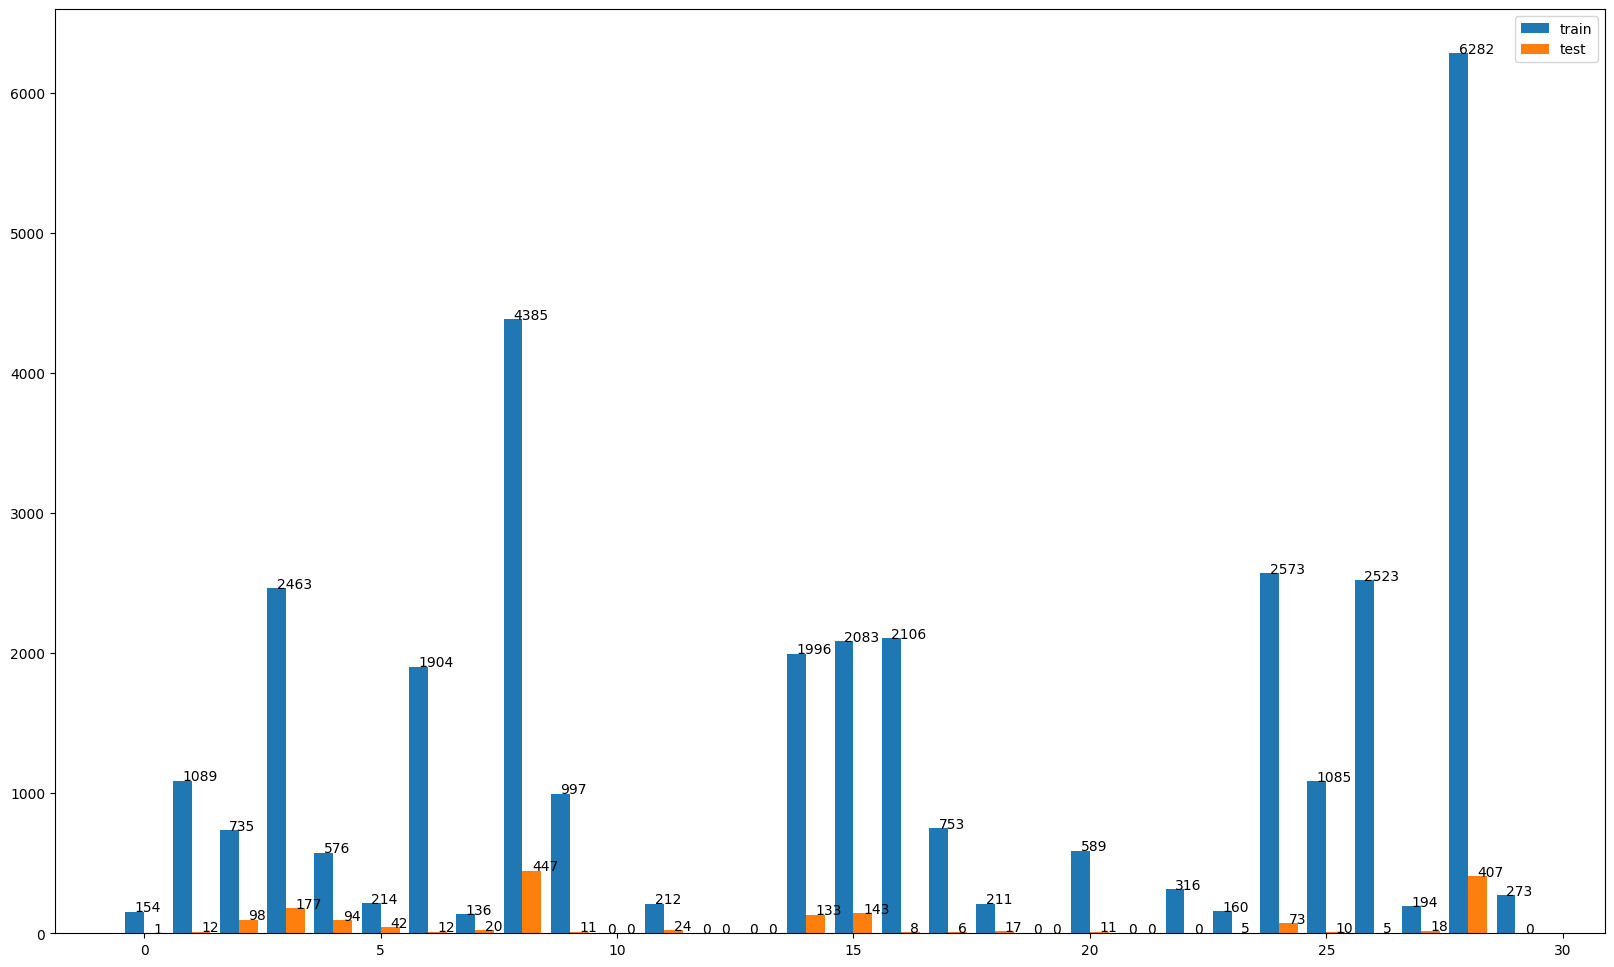

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

n_classes = int(train_y.shape[1])   # type: ignore

plt.figure(figsize=(20, 12))
xs = np.arange(n_classes)
train_bar = tf.reduce_sum(train_y, axis=0).numpy()
test_bar = tf.reduce_sum(test_y, axis=0).numpy()

plt.bar(xs - 0.2, train_bar, 0.4)
for i, x in enumerate(xs - 0.2):
    plt.text(x, train_bar[i], str(int(train_bar[i])))

plt.bar(xs + 0.2, test_bar, 0.4)
for i, x in enumerate(xs + 0.2):
    plt.text(x, test_bar[i], str(int(test_bar[i])))

plt.legend(['train', 'test'])
plt.show()

# Train the model

In [8]:
dropout_rate = 0.1
lr = 0.0005
patience = 10
hid_1, hid_2 = 1024, 512
epochs = 30 #100 30 should be enough

In [9]:
from keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(hid_1, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(hid_2, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(n_classes, activation='sigmoid')#, bias_initializer=output_bias)
], name='model')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=patience,
                                            restore_best_weights=True)

history = model.fit(train_x,
                    train_y,
                    epochs=epochs,
                    validation_data=(test_x, test_y),
                    callbacks=callback)


Epoch 1/30
889/889 [==============================] - 34s 36ms/step - loss: 0.1929 - val_loss: 0.1157
Epoch 2/30
889/889 [==============================] - 34s 39ms/step - loss: 0.1013 - val_loss: 0.1030
Epoch 3/30
889/889 [==============================] - 33s 38ms/step - loss: 0.0906 - val_loss: 0.0941
Epoch 4/30
889/889 [==============================] - 34s 39ms/step - loss: 0.0856 - val_loss: 0.0939
Epoch 5/30
889/889 [==============================] - 34s 38ms/step - loss: 0.0825 - val_loss: 0.0924
Epoch 6/30
889/889 [==============================] - 34s 38ms/step - loss: 0.0802 - val_loss: 0.0920
Epoch 7/30
889/889 [==============================] - 34s 39ms/step - loss: 0.0786 - val_loss: 0.0916
Epoch 8/30
889/889 [==============================] - 35s 39ms/step - loss: 0.0771 - val_loss: 0.0906
Epoch 9/30
889/889 [==============================] - 35s 40ms/step - loss: 0.0758 - val_loss: 0.0901
Epoch 10/30
889/889 [==============================] - 35s 39ms/step - loss: 0.074

In [10]:
pred_y = model.predict(test_x)

51/51 [==============================] - 0s 4ms/step


# Model evaluation

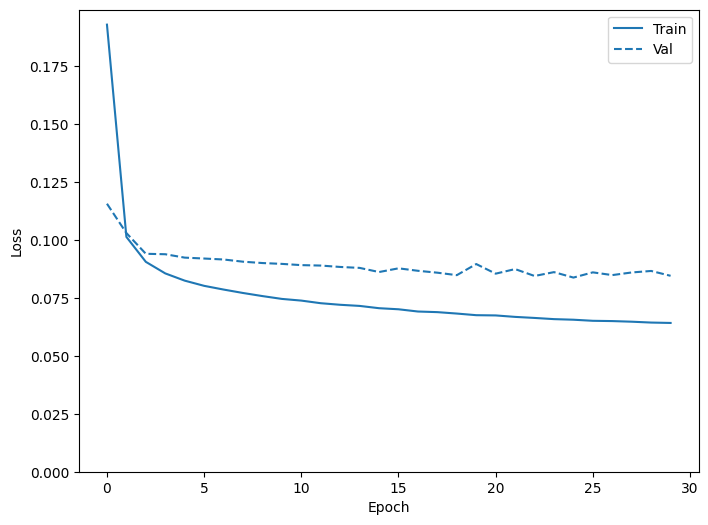

In [11]:
from evaluate import plot_history

plot_history(history)

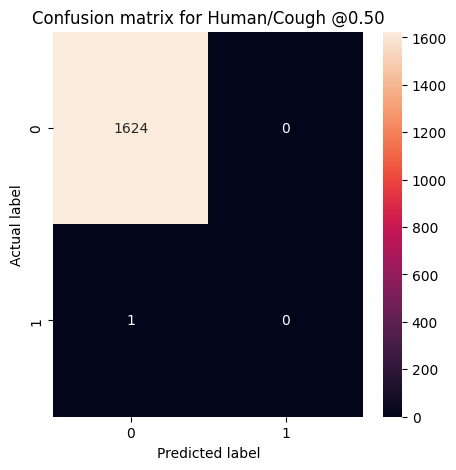

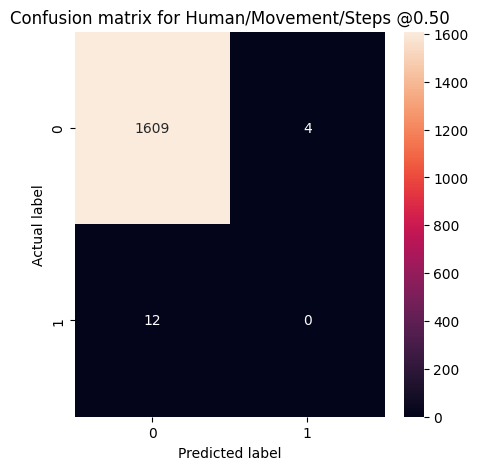

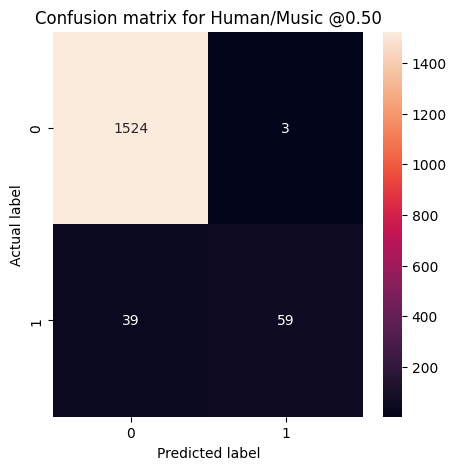

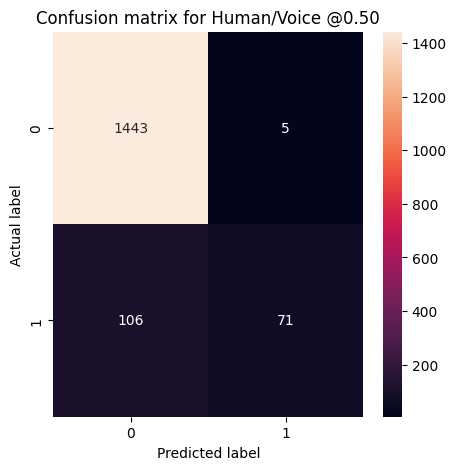

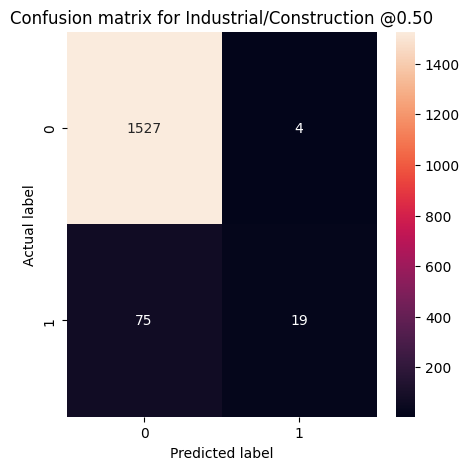

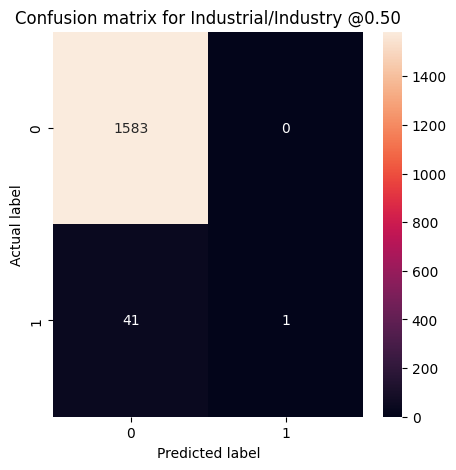

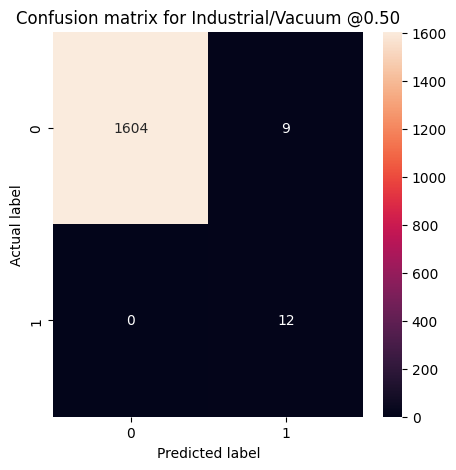

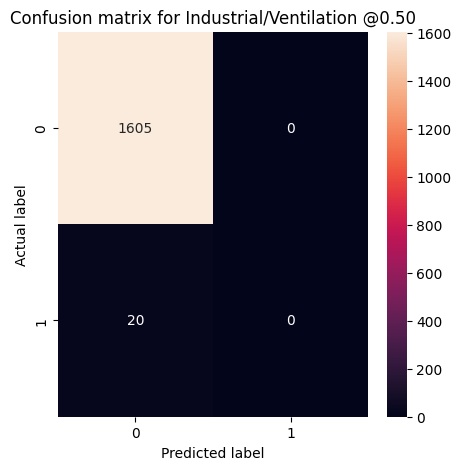

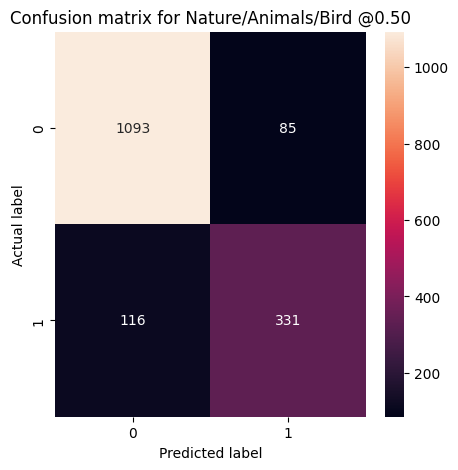

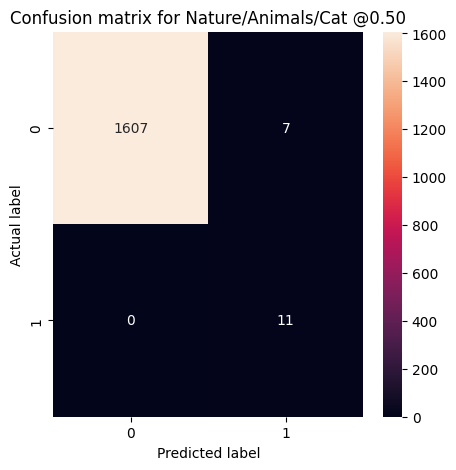

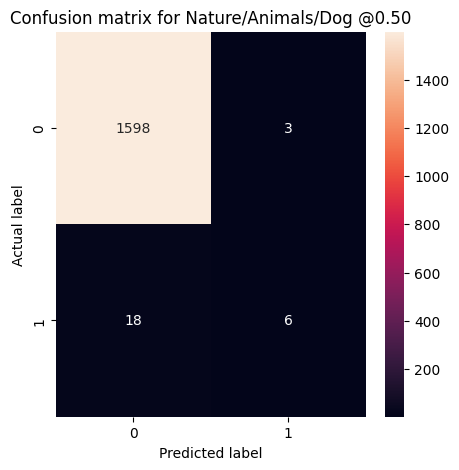

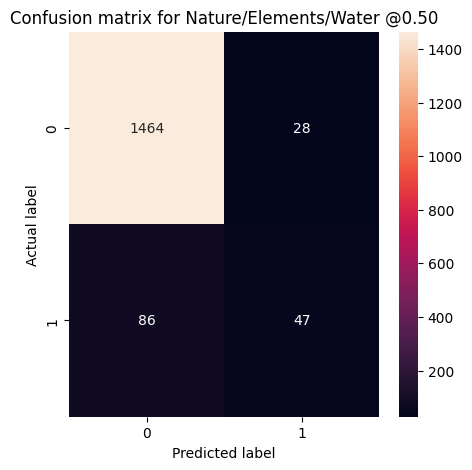

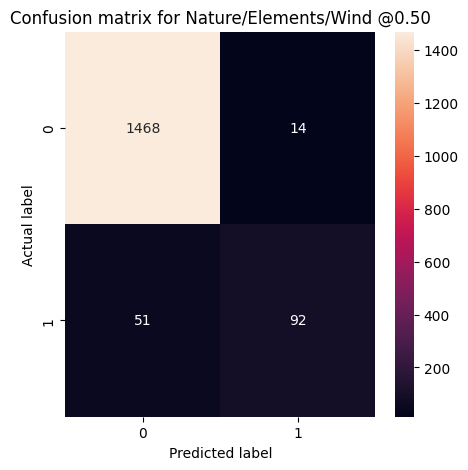

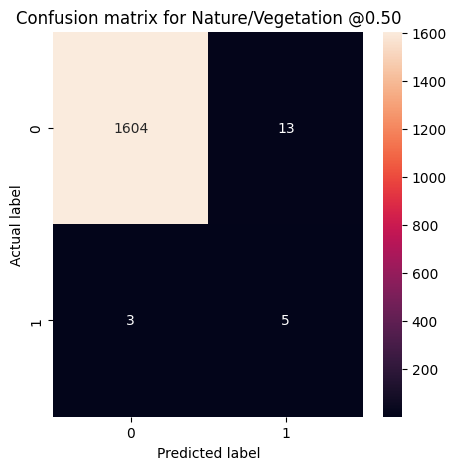

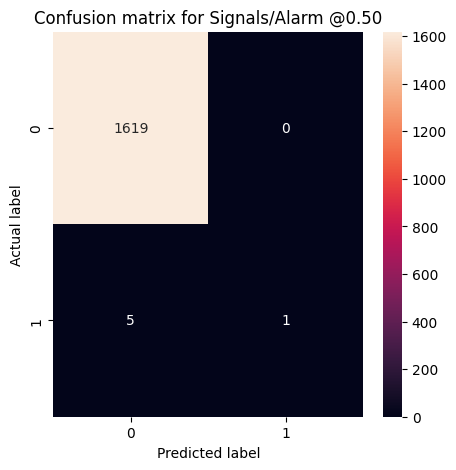

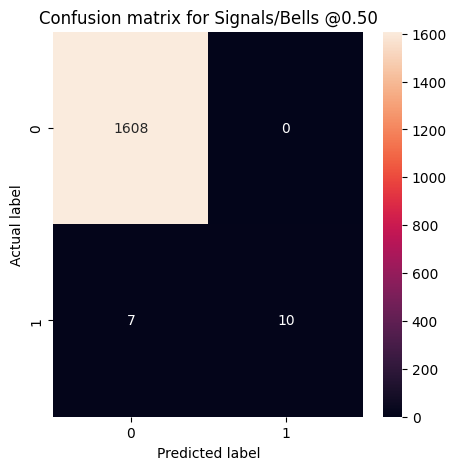

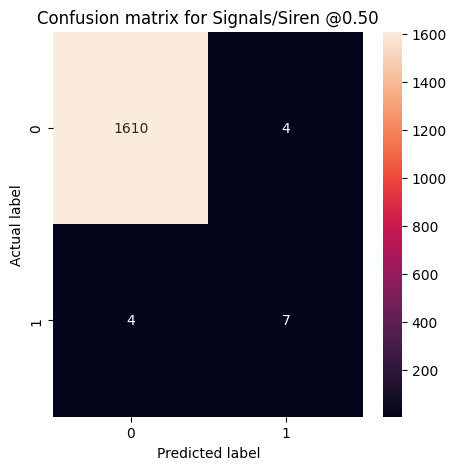

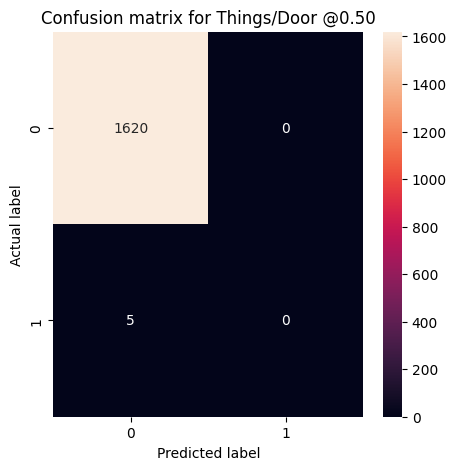

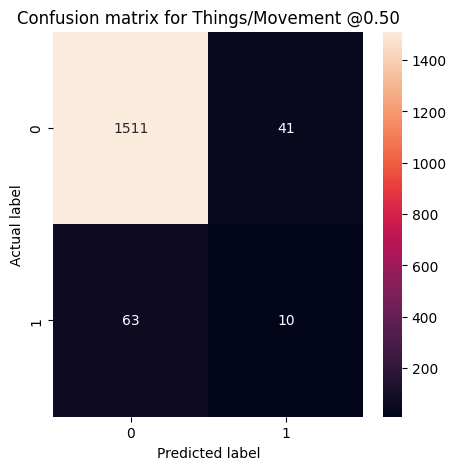

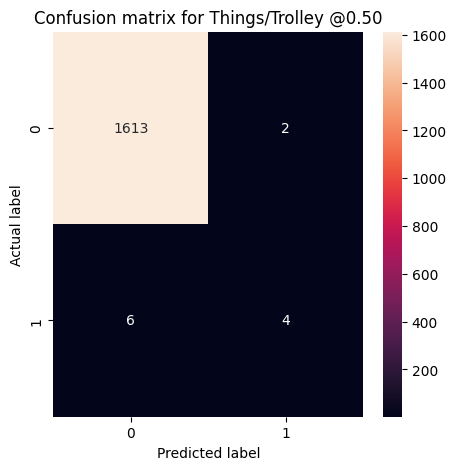

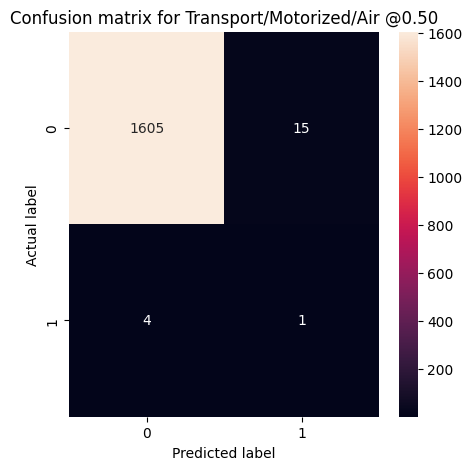

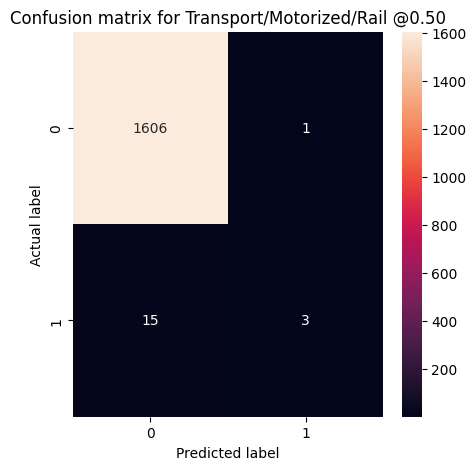

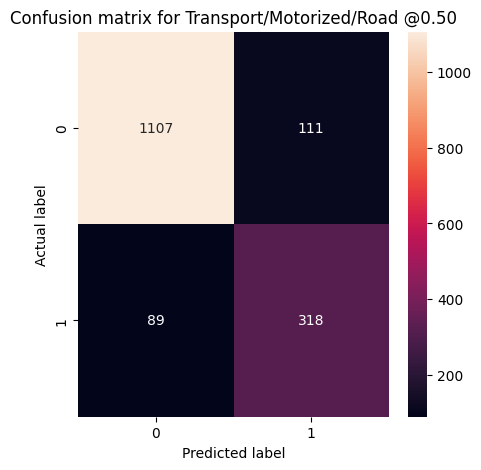

Metrics:
	accuracy: 0.5403
	balanced_accuracy: 0.7609
	precision_macro: 0.4394
	recall_macro: 0.2973
	f1_macro: 0.3105
	precision_micro: 0.7428
	recall_micro: 0.5682
	f1_micro: 0.6439
Per-class metrics:
	Human/Cough:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Human/Movement/Steps:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Human/Music:
		precision: 0.9516
		recall: 0.6020
		f1: 0.7375
	Human/Voice:
		precision: 0.9342
		recall: 0.4011
		f1: 0.5613
	Industrial/Construction:
		precision: 0.8261
		recall: 0.2021
		f1: 0.3248
	Industrial/Industry:
		precision: 1.0000
		recall: 0.0238
		f1: 0.0465
	Industrial/Vacuum:
		precision: 0.5714
		recall: 1.0000
		f1: 0.7273
	Industrial/Ventilation:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Nature/Animals/Bird:
		precision: 0.7957
		recall: 0.7405
		f1: 0.7671
	Nature/Animals/Cat:
		precision: 0.6111
		recall: 1.0000
		f1: 0.7586
	Nature/Animals/Cricket:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Nature/Animals/Dog:


In [12]:
from evaluate import evaluate

evaluate(test_y, pred_y, threshold=0.5)

In [13]:
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(f"Threshold: {threshold}")
    evaluate(test_y, pred_y, threshold=threshold, plot_confusion_matrices=False)

Threshold: 0.1


/home/daniele/Desktop/visiting_BCN/bcn_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/daniele/Desktop/visiting_BCN/bcn_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Metrics:
	accuracy: 0.3015
	balanced_accuracy: 0.8225
	precision_macro: 0.2530
	recall_macro: 0.4586
	f1_macro: 0.2882
	precision_micro: 0.4177
	recall_micro: 0.7988
	f1_micro: 0.5486
Per-class metrics:
	Human/Cough:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Human/Movement/Steps:
		precision: 0.0385
		recall: 0.3333
		f1: 0.0690
	Human/Music:
		precision: 0.6667
		recall: 0.8367
		f1: 0.7421
	Human/Voice:
		precision: 0.5580
		recall: 0.7062
		f1: 0.6234
	Industrial/Construction:
		precision: 0.5000
		recall: 0.3723
		f1: 0.4268
	Industrial/Industry:
		precision: 0.4444
		recall: 0.1905
		f1: 0.2667
	Industrial/Vacuum:
		precision: 0.2609
		recall: 1.0000
		f1: 0.4138
	Industrial/Ventilation:
		precision: 0.4286
		recall: 0.3000
		f1: 0.3529
	Nature/Animals/Bird:
		precision: 0.5273
		recall: 0.9284
		f1: 0.6726
	Nature/Animals/Cat:
		precision: 0.1341
		recall: 1.0000
		f1: 0.2366
	Nature/Animals/Cricket:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Nature/Animals/Dog:


/home/daniele/Desktop/visiting_BCN/bcn_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/daniele/Desktop/visiting_BCN/bcn_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Per-class metrics:
	Human/Cough:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Human/Movement/Steps:
		precision: 0.0476
		recall: 0.0833
		f1: 0.0606
	Human/Music:
		precision: 0.9054
		recall: 0.6837
		f1: 0.7791
	Human/Voice:
		precision: 0.8571
		recall: 0.5085
		f1: 0.6383
	Industrial/Construction:
		precision: 0.7429
		recall: 0.2766
		f1: 0.4031
	Industrial/Industry:
		precision: 0.2000
		recall: 0.0238
		f1: 0.0426
	Industrial/Vacuum:
		precision: 0.4800
		recall: 1.0000
		f1: 0.6486
	Industrial/Ventilation:
		precision: 0.5000
		recall: 0.0500
		f1: 0.0909
	Nature/Animals/Bird:
		precision: 0.7019
		recall: 0.8166
		f1: 0.7549
	Nature/Animals/Cat:
		precision: 0.3793
		recall: 1.0000
		f1: 0.5500
	Nature/Animals/Cricket:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Nature/Animals/Dog:
		precision: 0.7333
		recall: 0.4583
		f1: 0.5641
	Nature/Animals/Sheep:
		precision: 0.0000
		recall: 0.0000
		f1: 0.0000
	Nature/Elements/Thunder:
		precision: 0.0000
		recall: 0.000